# 机器翻译的神经网络实现

本节课我们讲述了利用编码器－解码器架构实现汉－英机器翻译。

整个代码包括了数据预处理、编码器＋简单解码器以及编码器＋带有注意力机制的解码器三个部分组成。

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VIII课的配套源代码

In [14]:
# 用到的包
#from __future__ import unicode_literals, print_function, division
# 进行系统操作，如io、正则表达式的包
from io import open
import unicodedata
import string
import re
import random
#import time
#import math

#Pytorch必备的包
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.utils.data as DataSet


# 绘图所用的包
import matplotlib.pyplot as plt
import numpy as np


# 判断本机是否有支持的GPU
use_cuda = torch.cuda.is_available()
#use_cuda = False
# 即时绘图
%matplotlib inline



# 一、数据准备

从硬盘读取语料文件，进行基本的预处理

In [2]:
# 读取平行语料库
# 这是人民日报语料库
lines = open('data/chinese.txt', encoding = 'utf-8')
chinese = lines.read().strip().split('\n')
lines = open('data/english.txt', encoding = 'utf-8')
english = lines.read().strip().split('\n')
print(len(chinese))
print(len(english))


100000
100000


In [3]:
# 定义两个特殊符号，分别对应句子头和句子尾
SOS_token = 0
EOS_token = 1


# 定义一个语言类，方便进行自动的建立、词频的统计等
# 在这个对象中，最重要的是两个字典：word2index，index2word
# 故名思议，第一个字典是将word映射到索引，第二个是将索引映射到word
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        # 在语言中添加一个新句子，句子是用空格隔开的一组单词
        # 将单词切分出来，并分别进行处理
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # 插入一个单词，如果单词已经在字典中，则更新字典中对应单词的频率
        # 同时建立反向索引，可以从单词编号找到单词
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
# 将unicode编码转变为ascii编码
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 把输入的英文字符串转成小写
def normalizeEngString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# 对输入的单词对做过滤，保证每句话的单词数不能超过MAX_LENGTH
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

# 输入一个句子，输出一个单词对应的编码序列
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


# 和上面的函数功能类似，不同在于输出的序列等长＝MAX_LENGTH
def indexFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    for i in range(MAX_LENGTH - len(indexes)):
        indexes.append(EOS_token)
    return(indexes)

# 从一个词对到下标
def indexFromPair(pair):
    input_variable = indexFromSentence(input_lang, pair[0])
    target_variable = indexFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

# 从一个列表到句子
def SentenceFromList(lang, lst):
    result = [lang.index2word[i] for i in lst if i != EOS_token]
    if lang.name == 'Chinese':
        result = ' '.join(result)
    else:
        result = ' '.join(result)
    return(result)

# 计算准确度的函数
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    pred = pred.view(-1, 1)
    rights = pred.eq(labels.data).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [8]:
# 处理数据形成训练数据
# 设置句子的最大长度
MAX_LENGTH = 20

#对英文做标准化处理
pairs = [[normalizeEngString(eng), chi,] for chi, eng in zip(chinese, english)]

# 对句子对做过滤，处理掉那些超过MAX_LENGTH长度的句子
input_lang = Lang('English')
output_lang = Lang('Chinese')
pairs = [pair for pair in pairs if filterPair(pair)]
print('有效句子对：', len(pairs))

# 建立两个字典（中文的和英文的）
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
print("总单词数:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


# 形成训练集，首先，打乱所有句子的顺序
random_idx = np.random.permutation(range(len(pairs)))
pairs = [pairs[i] for i in random_idx]

# 将语言转变为单词的编码构成的序列
pairs = [indexFromPair(pair) for pair in pairs]
    
# 形成训练集、校验集和测试集
valid_size = len(pairs) // 10
if valid_size > 10000:
    valid_size = 10000
pairs = pairs[ : - valid_size]
valid_pairs = pairs[-valid_size : -valid_size // 2]
test_pairs = pairs[- valid_size // 2 :]

# 利用PyTorch的dataset和dataloader对象，将数据加载到加载器里面，并且自动分批

batch_size = 1024 #一撮包含30个数据记录，这个数字越大，系统在训练的时候，每一个周期处理的数据就越多，这样处理越快，但总的数据量会减少

print('训练记录：', len(pairs))
print('校验记录：', len(valid_pairs))
print('测试记录：', len(test_pairs))

# 形成训练对列表，用于喂给train_dataset
pairs_X = [pair[0] for pair in pairs]
pairs_Y = [pair[1] for pair in pairs]
valid_X = [pair[0] for pair in valid_pairs]
valid_Y = [pair[1] for pair in valid_pairs]
test_X = [pair[0] for pair in test_pairs]
test_Y = [pair[1] for pair in test_pairs]


# 形成训练集
train_dataset = DataSet.TensorDataset(torch.LongTensor(pairs_X), torch.LongTensor(pairs_Y))
# 形成数据加载器
train_loader = DataSet.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)


# 校验数据
valid_dataset = DataSet.TensorDataset(torch.LongTensor(valid_X), torch.LongTensor(valid_Y))
valid_loader = DataSet.DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

# 测试数据
test_dataset = DataSet.TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_Y))
test_loader = DataSet.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)


有效句子对： 19919
总单词数:
English 13493
Chinese 18671
训练记录： 17928
校验记录： 995
测试记录： 996


# 二、构建编码器及简单的解码器RNN

In [5]:
# 构建编码器RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        # 第一层Embeddeing
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 第二层GRU，注意GRU中可以定义很多层，主要靠num_layers控制
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True, 
                          num_layers = self.n_layers, bidirectional = True)

    def forward(self, input, hidden):
        #前馈过程
        #input尺寸： batch_size, length_seq
        embedded = self.embedding(input)
        #embedded尺寸：batch_size, length_seq, hidden_size
        output = embedded
        output, hidden = self.gru(output, hidden)
        # output尺寸：batch_size, length_seq, hidden_size
        # hidden尺寸：num_layers * directions, batch_size, hidden_size
        return output, hidden

    def initHidden(self, batch_size):
        # 对隐含单元变量全部进行初始化
        #num_layers * num_directions, batch, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

# 解码器网络
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        # 嵌入层
        self.embedding = nn.Embedding(output_size, hidden_size)
        # GRU单元
        # 设置batch_first为True的作用就是为了让GRU接受的张量可以和其它单元类似，第一个维度为batch_size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True,
                        num_layers = self.n_layers, bidirectional = True)
        # 最后的全链接层
        self.out = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        # input大小：batch_size, length_seq
        output = self.embedding(input)
        # embedded大小：batch_size, length_seq, hidden_size
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # output大小：batch_size, length_seq, hidden_size * directions
        # hidden大小：n_layers * directions, batch_size, hidden_size
        output = self.softmax(self.out(output[:, -1, :]))
        # output大小：batch_size * output_size
        # 从output中取时间步重新开始
        
        return output, hidden

    def initHidden(self):
        # 初始化隐含单元的状态，输入变量的尺寸：num_layers * directions, batch_size, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [9]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
# 开始训练过程
# 定义网络结构
start = time.time()

hidden_size = 512
max_length = MAX_LENGTH
n_layers = 1

encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers = n_layers)
decoder = DecoderRNN(hidden_size, output_lang.n_words, n_layers = n_layers)

if use_cuda:
    # 如果本机有GPU可用，则将模型加载到GPU上
    encoder = encoder.cuda()
    decoder = decoder.cuda()

learning_rate = 0.01
# 为两个网络分别定义优化器
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

# 定义损失函数
criterion = nn.NLLLoss()
teacher_forcing_ratio = 0.5

plot_losses = []

# 开始200轮的循环
num_epoch = 100
for epoch in range(num_epoch):
    print_loss_total = 0
    # 对训练数据循环
    for data in train_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable的大小：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable的大小：batch_size, length_seq
        
        # 初始化编码器状态
        encoder_hidden = encoder.initHidden(data[0].size()[0])
        # 清空梯度
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        loss = 0

        # 开始编码器的计算，对时间步的循环由系统自动完成
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
        # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size
        
        # 开始解码器的工作
        # 输入给解码器的第一个字符
        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        # 让解码器的隐藏层状态等于编码器的隐藏层状态
        decoder_hidden = encoder_hidden
        # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

        # 以teacher_forcing_ratio的比例用target中的翻译结果作为监督信息
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        base = torch.zeros(target_variable.size()[0])
        if use_teacher_forcing:
            # 教师监督: 将下一个时间步的监督信息输入给解码器
            # 对时间步循环
            for di in range(MAX_LENGTH):
                # 开始一步解码
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # decoder_ouput大小：batch_size, output_size
                # 计算损失函数
                loss += criterion(decoder_output, target_variable[:, di])
                # 将训练数据当做下一时间步的输入
                decoder_input = target_variable[:, di].unsqueeze(1)  # Teacher forcing
                # decoder_input大小：batch_size, length_seq
                
        else:
            # 没有教师训练: 使用解码器自己的预测作为下一时间步的输入
            # 开始对时间步进行循环
            for di in range(MAX_LENGTH):
                # 进行一步解码
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                #decoder_ouput大小：batch_size, output_size(vocab_size)
                
                #从输出结果（概率的对数值）中选择出一个数值最大的单词作为输出放到了topi中
                topv, topi = decoder_output.data.topk(1, dim = 1)
                #topi 尺寸：batch_size, k
                ni = topi[:, 0]

                # 将输出结果ni包裹成Variable作为解码器的输入
                decoder_input = Variable(ni.unsqueeze(1))
                # decoder_input大小：batch_size, length_seq
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input

                #计算损失函数
                loss += criterion(decoder_output, target_variable[:, di])
        
            
        
        # 开始反向传播
        loss.backward()
        loss = loss.cpu() if use_cuda else loss
        # 开始梯度下降
        encoder_optimizer.step()
        decoder_optimizer.step()
        # 累加总误差
        print_loss_total += loss.data.numpy()[0]

    # 计算训练时候的平均误差
    print_loss_avg = print_loss_total / len(train_loader)
        
    # 开始跑校验数据集
    valid_loss = 0
    rights = []
    # 对校验数据集循环
    for data in valid_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable的大小：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable的大小：batch_size, length_seq

        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
        # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        decoder_hidden = encoder_hidden
        # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

        # 没有教师监督: 使用解码器自己的预测作为下一时间步解码器的输入
        for di in range(MAX_LENGTH):
            # 一步解码器运算
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #decoder_ouput大小：batch_size, output_size(vocab_size)
            
            # 选择输出最大的项作为解码器的预测答案
            topv, topi = decoder_output.data.topk(1, dim = 1)
            #topi 尺寸：batch_size, k
            ni = topi[:, 0]
            decoder_input = Variable(ni.unsqueeze(1))
            # decoder_input大小：batch_size, length_seq
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            
            # 计算预测的准确率，记录在right中，right为一个二元组，分别存储猜对的个数和总数
            right = rightness(decoder_output, target_variable[:, di].unsqueeze(1))
            rights.append(right)
            
            # 计算损失函数
            loss += criterion(decoder_output, target_variable[:, di])
        loss = loss.cpu() if use_cuda else loss
        # 累加校验时期的损失函数
        valid_loss += loss.data.numpy()[0]
    # 打印每一个Epoch的输出结果
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('进程：%d%% 训练损失：%.4f，校验损失：%.4f，词正确率：%.2f%%, at %s ' % (epoch * 1.0 / num_epoch * 100, 
                                                    print_loss_avg,
                                                    valid_loss / len(valid_loader),
                                                    100.0 * right_ratio,
                                                    time_since(start)))
    # 记录基本统计指标
    plot_losses.append([print_loss_avg, valid_loss / len(valid_loader), right_ratio])
    

进程：0% 训练损失：156.7983，校验损失：117.3300，词正确率：38.64%, at 0m 9s 
进程：1% 训练损失：104.7127，校验损失：99.7316，词正确率：40.19%, at 0m 18s 
进程：2% 训练损失：91.1028，校验损失：85.7994，词正确率：34.65%, at 0m 27s 
进程：3% 训练损失：78.3524，校验损失：78.3611，词正确率：37.07%, at 0m 35s 
进程：4% 训练损失：74.0956，校验损失：76.2644，词正确率：39.42%, at 0m 44s 
进程：5% 训练损失：74.1638，校验损失：79.6615，词正确率：40.65%, at 0m 53s 
进程：6% 训练损失：74.2794，校验损失：80.9193，词正确率：39.40%, at 1m 2s 
进程：7% 训练损失：78.4859，校验损失：88.4677，词正确率：33.68%, at 1m 10s 
进程：8% 训练损失：79.1147，校验损失：83.4899，词正确率：36.39%, at 1m 19s 
进程：9% 训练损失：79.6772，校验损失：83.1703，词正确率：37.09%, at 1m 28s 
进程：10% 训练损失：77.8872，校验损失：80.7215，词正确率：41.53%, at 1m 37s 
进程：11% 训练损失：74.8109，校验损失：80.6421，词正确率：44.72%, at 1m 45s 
进程：12% 训练损失：71.5768，校验损失：75.8461，词正确率：43.93%, at 1m 54s 
进程：13% 训练损失：70.6515，校验损失：70.5725，词正确率：44.95%, at 2m 3s 
进程：14% 训练损失：66.9751，校验损失：69.0901，词正确率：45.39%, at 2m 12s 
进程：15% 训练损失：64.9716，校验损失：65.8245，词正确率：46.83%, at 2m 21s 
进程：16% 训练损失：63.6059，校验损失：65.5168，词正确率：47.44%, at 2m 29s 
进程：17% 训练损失：61.2257，校验损失：62.3979，词正确率：47.

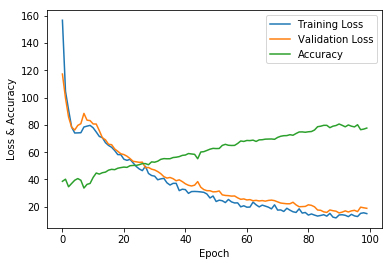

In [12]:
# 将统计指标绘图
a = [i[0] for i in plot_losses]
b = [i[1] for i in plot_losses]
c = [i[2] * 100 for i in plot_losses]
plt.plot(a, label = 'Training Loss')
plt.plot(b, label = 'Validation Loss')
plt.plot(c, label = 'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [16]:
# 在测试集上测试模型运行的效果

# 首先，在测试集中随机选择20个句子作为测试
indices = np.random.choice(range(len(test_X)), 20)

# 对每个句子进行循环
for ind in indices:
    data = [test_X[ind]]
    target = [test_Y[ind]]
    # 把源语言的句子打印出来
    print(SentenceFromList(input_lang, data[0]))
    input_variable = Variable(torch.LongTensor(data)).cuda() if use_cuda else Variable(torch.LongTensor(data))
    # input_variable的大小：batch_size, length_seq
    target_variable = Variable(torch.LongTensor(target)).cuda() if use_cuda else Variable(torch.LongTensor(target))
    # target_variable的大小：batch_size, length_seq

    # 初始化编码器
    encoder_hidden = encoder.initHidden(input_variable.size()[0])

    loss = 0
    
    # 编码器开始编码，结果存储到了encoder_hidden中
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
    # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

    # 将SOS作为解码器的第一个输入
    decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
    # decoder_input大小：batch_size, length_seq
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    # 将编码器的隐含层单元数值拷贝给解码器的隐含层单元
    decoder_hidden = encoder_hidden
    # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

    # 没有教师指导下的预测: 使用解码器自己的预测作为解码器下一时刻的输入
    output_sentence = []
    decoder_attentions = torch.zeros(max_length, max_length)
    rights = []
    # 按照输出字符进行时间步循环
    for di in range(MAX_LENGTH):
        # 解码器一个时间步的计算
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        #decoder_ouput大小：batch_size, output_size(vocab_size)
        
        # 解码器的输出
        topv, topi = decoder_output.data.topk(1, dim = 1)
        #topi 尺寸：batch_size, k
        ni = topi[:, 0]
        decoder_input = Variable(ni.unsqueeze(1))
        ni = ni.cpu().numpy()[0]
        
        # 将本时间步输出的单词编码加到output_sentence里面
        output_sentence.append(ni)
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        
        # 计算输出字符的准确度
        right = rightness(decoder_output, target_variable[:, di].unsqueeze(1))
        rights.append(right)
    # 解析出编码器给出的翻译结果
    sentence = SentenceFromList(output_lang, output_sentence)
    # 解析出标准答案
    standard = SentenceFromList(output_lang, target[0])
    
    # 将句子打印出来
    print('机器翻译：', sentence)
    print('标准翻译：', standard)
    # 输出本句话的准确率
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('词准确率：', 100.0 * right_ratio)
    print('\n')

zhu bangzao said settling disputes through peaceful negotiations is the only correct available option for israel and palestine .
机器翻译： 朱邦造 说 , 以 巴 之间 通过 和平谈判 解决 彼此 争端 是 唯一 可供 选择 的 正确 道路 .
标准翻译： 朱邦造 说 , 以 巴 之间 通过 和平谈判 解决 彼此 争端 是 唯一 可供 选择 的 正确 道路 .
词准确率： 100.0


health permitting he said he would continue to stay here .
机器翻译： 如果 身体 条件 的话 的话 , 身体 想 的话 , 一直 干 下去 .
标准翻译： 如果 身体 条件 允许 的话 , 他 想 在这里 一直 干 下去 .
词准确率： 60.0


when forms are put in the first place contents must be subordinated to forms .
机器翻译： 形式 形式 首位 , 要 反而 要 服从 形式 形式 .
标准翻译： 形式 变成 首位 , 内容 反而 要 服从 形式 .
词准确率： 80.0


the fact is many countries have already spoken out on us human rights conditions .
机器翻译： 事实上 , 许多 国家 已经 对 美国 的 人权 状况 说话 了 .
标准翻译： 事实上 , 许多 国家 已经 对 美国 的 人权 状况 说话 了 .
词准确率： 100.0


the outline draft sketches the blueprint for construction in the first five years of the new century .
机器翻译： ( 纲要 草案 ) 勾画出 了 新世纪 ) 新世纪 的 第一 年 .
标准翻译： 纲要 ( 草案 ) 勾画出 了 新世纪 第一 五 年 的 建设 蓝图 .
词准确率： 55.0


his sudden death brought to light the succes

# Attention Model

In [17]:
# 重新处理数据形成训练数据、校验数据与测试数据，主要是MAX_Length更大了
# 设置句子的最大长度
MAX_LENGTH = 20

#对英文做标准化处理
pairs = [[normalizeEngString(eng), chi] for chi, eng in zip(chinese, english)]

# 对句子对做过滤，处理掉那些超过MAX_LENGTH长度的句子
input_lang = Lang('English')
output_lang = Lang('Chinese')
pairs = [pair for pair in pairs if filterPair(pair)]
print('有效句子对：', len(pairs))

# 建立两个字典（中文的和英文的）
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
print("总单词数:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


# 形成训练集，首先，打乱所有句子的顺序
random_idx = np.random.permutation(range(len(pairs)))
pairs = [pairs[i] for i in random_idx]

# 将语言转变为单词的编码构成的序列
pairs = [indexFromPair(pair) for pair in pairs]
    
# 形成训练集、校验集和测试集
valid_size = len(pairs) // 10
if valid_size > 10000:
    valid_size = 10000
pairs = pairs[ : - valid_size]
valid_pairs = pairs[-valid_size : -valid_size // 2]
test_pairs = pairs[- valid_size // 2 :]

# 利用PyTorch的dataset和dataloader对象，将数据加载到加载器里面，并且自动分批

batch_size = 30 #一撮包含30个数据记录，这个数字越大，系统在训练的时候，每一个周期处理的数据就越多，这样处理越快，但总的数据量会减少

print('训练记录：', len(pairs))
print('校验记录：', len(valid_pairs))
print('测试记录：', len(test_pairs))

# 形成训练对列表，用于喂给train_dataset
pairs_X = [pair[0] for pair in pairs]
pairs_Y = [pair[1] for pair in pairs]
valid_X = [pair[0] for pair in valid_pairs]
valid_Y = [pair[1] for pair in valid_pairs]
test_X = [pair[0] for pair in test_pairs]
test_Y = [pair[1] for pair in test_pairs]


# 形成训练集
train_dataset = DataSet.TensorDataset(torch.LongTensor(pairs_X), torch.LongTensor(pairs_Y))
# 形成数据加载器
train_loader = DataSet.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)


# 校验数据
valid_dataset = DataSet.TensorDataset(torch.LongTensor(valid_X), torch.LongTensor(valid_Y))
valid_loader = DataSet.DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

# 测试数据
test_dataset = DataSet.TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_Y))
test_loader = DataSet.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)


有效句子对： 19919
总单词数:
English 13493
Chinese 18671
训练记录： 17928
校验记录： 995
测试记录： 996


In [19]:
# 定义基于注意力的解码器RNN
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        # 词嵌入层
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        # 注意力网络（一个前馈神经网络）
        self.attn = nn.Linear(self.hidden_size * (2 * n_layers + 1), self.max_length)
    
        # 注意力机制作用完后的结果映射到后面的层
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        
        # dropout操作层
        self.dropout = nn.Dropout(self.dropout_p)
        
        # 定义一个双向GRU，并设置batch_first为True以方便操作
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, bidirectional = True,
                         num_layers = self.n_layers, batch_first = True)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # 解码器的一步操作
        # input大小：batch_size, length_seq
        embedded = self.embedding(input)
        # embedded大小：batch_size, length_seq, hidden_size
        embedded = embedded[:, 0, :]
        # embedded大小：batch_size, hidden_size
        embedded = self.dropout(embedded)
        
        # 将hidden张量数据转化成batch_size排在第0维的形状
        # hidden大小：direction*n_layer, batch_size, hidden_size
        temp_for_transpose = torch.transpose(hidden, 0, 1).contiguous()
        temp_for_transpose = temp_for_transpose.view(temp_for_transpose.size()[0], -1)
        hidden_attn = temp_for_transpose
        
        # 注意力层的输入
        # hidden_attn大小：batch_size, direction*n_layers*hidden_size
        input_to_attention = torch.cat((embedded, hidden_attn), 1)
        # input_to_attention大小：batch_size, hidden_size * (1 + direction * n_layers)
        
        # 注意力层输出的权重
        attn_weights = F.softmax(self.attn(input_to_attention))
        # attn_weights大小：batch_size, max_length
        
        # 当输入数据不标准的时候，对weights截取必要的一段
        attn_weights = attn_weights[:, : encoder_outputs.size()[1]]
        # attn_weights大小：batch_size, length_seq_of_encoder
        attn_weights = attn_weights.unsqueeze(1)
        # attn_weights大小：batch_size, 1, length_seq 中间的1是为了bmm乘法用的
        
        # 将attention的weights矩阵乘encoder_outputs以计算注意力完的结果
        # encoder_outputs大小：batch_size, seq_length, hidden_size*direction
        attn_applied = torch.bmm(attn_weights, encoder_outputs) 
        # attn_applied大小：batch_size, 1, hidden_size*direction
        # bmm: 两个矩阵相乘。忽略第一个batch纬度，缩并时间维度
        
        # 将输入的词向量与注意力机制作用后的结果拼接成一个大的输入向量
        output = torch.cat((embedded, attn_applied[:,0,:]), 1)
        # output大小：batch_size, hidden_size * (direction + 1)
        
        # 将大输入向量映射为GRU的隐含层
        output = self.attn_combine(output).unsqueeze(1)
        # output大小：batch_size, length_seq, hidden_size
        output = F.relu(output)
        
        # output的结果再dropout
        output = self.dropout(output)

        # 开始解码器GRU的运算
        output, hidden = self.gru(output, hidden)
        
        
        # output大小：batch_size, length_seq, hidden_size * directions
        # hidden大小：n_layers * directions, batch_size, hidden_size
        
        #取出GRU运算最后一步的结果喂给最后一层全链接层
        output = self.out(output[:, -1, :])
        # output大小：batch_size * output_size
        
        # 取logsoftmax，计算输出结果
        output = F.log_softmax(output)
        # output大小：batch_size * output_size
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        # 初始化解码器隐单元，尺寸为n_layers * directions, batch_size, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [20]:
# 开始带有注意力机制的RNN训练

#定义网络架构
start = time.time()

hidden_size = 512
max_length = MAX_LENGTH
n_layers = 1
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers = n_layers)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.5,
                         max_length = max_length, n_layers = n_layers)

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

print_loss_total = 0  # Reset every print_every
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()
#criterion = Batch_NLLLoss
teacher_forcing_ratio = 0.5

num_epoch = 100

# 开始训练周期循环
plot_losses = []
for epoch in range(num_epoch):
    # 将解码器置于训练状态，让dropout工作
    decoder.train()
    print_loss_total = 0
    # 对训练数据进行循环
    for data in train_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable的大小：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable的大小：batch_size, length_seq
        
        #清空梯度
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0

        #编码器开始工作
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
        # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

        # 解码器开始工作
        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        # 将编码器的隐含层单元取值作为编码的结果传递给解码器
        decoder_hidden = encoder_hidden
        # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

        # 同时按照两种方式训练解码器：用教师监督的信息作为下一时刻的输入和不用监督的信息，用自己预测结果作为下一时刻的输入
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        if use_teacher_forcing:
            # 用监督信息作为下一时刻解码器的输入
            # 开始时间不得循环
            for di in range(MAX_LENGTH):
                # 输入给解码器的信息包括输入的单词decoder_input, 解码器上一时刻的因曾单元状态，
                # 编码器各个时间步的输出结果
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #decoder_ouput大小：batch_size, output_size
                #计算损失函数，得到下一时刻的解码器的输入
                loss += criterion(decoder_output, target_variable[:, di])
                decoder_input = target_variable[:, di].unsqueeze(1)  # Teacher forcing
                # decoder_input大小：batch_size, length_seq
        else:
            # 没有教师监督，用解码器自己的预测作为下一时刻的输入

            # 对时间步进行循环
            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #decoder_ouput大小：batch_size, output_size(vocab_size)
                # 获取解码器的预测结果，并用它来作为下一时刻的输入
                topv, topi = decoder_output.data.topk(1, dim = 1)
                #topi 尺寸：batch_size, k
                ni = topi[:, 0]

                decoder_input = Variable(ni.unsqueeze(1))
                # decoder_input大小：batch_size, length_seq
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input

                # 计算损失函数
                loss += criterion(decoder_output, target_variable[:, di])
        
        
        
        # 反向传播开始
        loss.backward()
        loss = loss.cpu() if use_cuda else loss
        # 开始梯度下降
        encoder_optimizer.step()
        decoder_optimizer.step()
        print_loss_total += loss.data.numpy()[0]

    print_loss_avg = print_loss_total / len(train_loader)
        
    valid_loss = 0
    rights = []
    # 将解码器的training设置为False，以便关闭dropout
    decoder.eval()
    
    #对所有的校验数据做循环
    for data in valid_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable的大小：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable的大小：batch_size, length_seq

        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
        # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        decoder_hidden = encoder_hidden
        # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

        # 开始每一步的预测
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_ouput大小：batch_size, output_size(vocab_size)
            topv, topi = decoder_output.data.topk(1, dim = 1)
            #topi 尺寸：batch_size, k
            ni = topi[:, 0]

            decoder_input = Variable(ni.unsqueeze(1))
            # decoder_input大小：batch_size, length_seq
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            right = rightness(decoder_output, target_variable[:, di].unsqueeze(1))
            rights.append(right)
            loss += criterion(decoder_output, target_variable[:, di])
        loss = loss.cpu() if use_cuda else loss
        valid_loss += loss.data.numpy()[0]
    # 计算平均损失、准确率等指标并打印输出
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('进程：%d%% 训练损失：%.4f，校验损失：%.4f，词正确率：%.2f%% at %s' % (epoch * 1.0 / num_epoch * 100, 
                                                    print_loss_avg,
                                                    valid_loss / len(valid_loader),
                                                    100.0 * right_ratio,
                                                    time_since(start)))
    plot_losses.append([print_loss_avg, valid_loss / len(valid_loader), right_ratio])
    

进程：0% 训练损失：91.2160，校验损失：87.4878，词正确率：42.58% at 1m 44s
进程：1% 训练损失：82.8542，校验损失：83.6274，词正确率：43.01% at 3m 28s
进程：2% 训练损失：78.7738，校验损失：79.9690，词正确率：43.72% at 5m 10s
进程：3% 训练损失：75.4363，校验损失：77.1736，词正确率：43.93% at 6m 54s
进程：4% 训练损失：72.5687，校验损失：73.8263，词正确率：44.49% at 8m 37s
进程：5% 训练损失：69.7428，校验损失：71.4972，词正确率：44.84% at 10m 20s
进程：6% 训练损失：66.9764，校验损失：68.6419，词正确率：45.38% at 11m 57s
进程：7% 训练损失：64.6855，校验损失：65.8239，词正确率：45.88% at 13m 39s
进程：8% 训练损失：62.3569，校验损失：63.8708，词正确率：46.55% at 15m 22s
进程：9% 训练损失：59.7454，校验损失：61.0601，词正确率：46.93% at 17m 5s
进程：10% 训练损失：57.6412，校验损失：58.5582，词正确率：47.54% at 18m 49s
进程：11% 训练损失：55.4660，校验损失：55.8455，词正确率：48.48% at 20m 33s
进程：12% 训练损失：53.4045，校验损失：53.6359，词正确率：49.54% at 22m 16s
进程：13% 训练损失：51.2436，校验损失：52.2306，词正确率：50.16% at 23m 59s
进程：14% 训练损失：49.3243，校验损失：50.1005，词正确率：51.08% at 25m 43s
进程：15% 训练损失：47.7357，校验损失：48.7334，词正确率：52.69% at 27m 28s
进程：16% 训练损失：45.9257，校验损失：46.9938，词正确率：52.87% at 29m 11s
进程：17% 训练损失：44.1392，校验损失：44.6821，词正确率：53.66% at 30m 55s
进程：18% 训

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


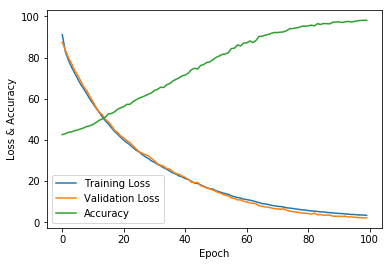

In [21]:
# 绘制统计指标曲线图
torch.save(encoder, 'encoder-final.mdl')
torch.save(decoder, 'decoder-final.mdl')
a = [i[0] for i in plot_losses]
b = [i[1] for i in plot_losses]
c = [i[2] * 100 for i in plot_losses]
plt.plot(a, label = 'Training Loss')
plt.plot(b, label = 'Validation Loss')
plt.plot(c, label = 'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [23]:
# 从测试集中随机挑选20个句子来测试翻译的结果
indices = np.random.choice(range(len(test_X)), 20)
for ind in indices:
    data = [test_X[ind]]
    target = [test_Y[ind]]
    print(SentenceFromList(input_lang, data[0]))
    input_variable = Variable(torch.LongTensor(data)).cuda() if use_cuda else Variable(torch.LongTensor(data))
    # input_variable的大小：batch_size, length_seq
    target_variable = Variable(torch.LongTensor(target)).cuda() if use_cuda else Variable(torch.LongTensor(target))
    # target_variable的大小：batch_size, length_seq

    encoder_hidden = encoder.initHidden(input_variable.size()[0])

    loss = 0
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    # encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
    # encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

    decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
    # decoder_input大小：batch_size, length_seq
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden
    # decoder_hidden大小：direction*n_layer, batch_size, hidden_size

    # Without teacher forcing: use its own predictions as the next input
    output_sentence = []
    decoder_attentions = torch.zeros(max_length, max_length)
    rights = []
    for di in range(MAX_LENGTH):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        #decoder_ouput大小：batch_size, output_size(vocab_size)
        topv, topi = decoder_output.data.topk(1, dim = 1)
        decoder_attentions[di] = decoder_attention.data
        #topi 尺寸：batch_size, k
        ni = topi[:, 0]
        decoder_input = Variable(ni.unsqueeze(1))
        ni = ni.cpu().numpy()[0]
        output_sentence.append(ni)
        # decoder_input大小：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        right = rightness(decoder_output, target_variable[:, di].unsqueeze(1))
        rights.append(right)
    sentence = SentenceFromList(output_lang, output_sentence)
    standard = SentenceFromList(output_lang, target[0])
    print('机器翻译：', sentence)
    print('标准翻译：', standard)
    # 输出本句话的准确率
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('词准确率：', 100.0 * right_ratio)
    print('\n')

he hoped to see a more active economic and trade relationship between the two sides in the future .
机器翻译： 希望 双方 经贸 关系 变得 更加 积极 .
标准翻译： 希望 双方 经贸 关系 变得 更加 积极 .
词准确率： 100.0


it is necessary to pursue and crack down on them relentlessly in a bid to uproot them all .
机器翻译： 五 是 加大 文化 市场 的 整治 力度 .
标准翻译： 五 是 加大 文化 市场 的 整治 力度 .
词准确率： 100.0


this may well be another awakening for the developing countries .
机器翻译： 这 不妨 看成是 发展中国家 的 又 一次 觉醒 .
标准翻译： 这 不妨 看成是 发展中国家 的 又 一次 觉醒 .
词准确率： 100.0


we must take this as a warning and the alarm bell should sound for a long time . .
机器翻译： 我们 必须 引以为戒 , 警钟 长鸣 .
标准翻译： 我们 必须 引以为戒 , 警钟 长鸣 .
词准确率： 100.0


we shall face severe challenges agriculturally after our country accedes to the wto .
机器翻译： 在 我国 加入 世贸 组织 之后 , 农业 将 面临 严峻 的 挑战 .
标准翻译： 在 我国 加入 世贸 组织 之后 , 农业 将 面临 严峻 的 挑战 .
词准确率： 100.0


he thanked the vietnamese government for its long term adherence to the one china policy .
机器翻译： 傅全有 对 越南 政府 长期以来 奉行 " 一个 中国 " 的 政策 表示 感谢 .
标准翻译： 傅全有 对 越南 政府 长期以来 奉行 " 一个 中国 " 的 政策 

In [39]:
# 通过几个特殊的句子翻译，考察注意力机制关注的情况
# data = '人民币 汇率 继续 保持 稳定 .'
# data = '五 是 干部 交流 工作 迈出 较大 步伐 .'
# data = '谈到 经济 合作 问题 , 两 人 找到 了 一些 共同 语言 .'
data = 'how to save taiwan ?'

data = np.array([indexFromSentence(input_lang, data)])

input_variable = Variable(torch.LongTensor(data)).cuda() if use_cuda else Variable(torch.LongTensor(data))
# input_variable的大小：batch_size, length_seq
target_variable = Variable(torch.LongTensor(target)).cuda() if use_cuda else Variable(torch.LongTensor(target))
# target_variable的大小：batch_size, length_seq

encoder_hidden = encoder.initHidden(input_variable.size()[0])

loss = 0
encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
# encoder_outputs的大小：batch_size, length_seq, hidden_size*direction
# encoder_hidden的大小：direction*n_layer, batch_size, hidden_size

decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
# decoder_input大小：batch_size, length_seq
decoder_input = decoder_input.cuda() if use_cuda else decoder_input

decoder_hidden = encoder_hidden
# decoder_hidden大小：direction*n_layer, batch_size, hidden_size

output_sentence = []
decoder_attentions = torch.zeros(max_length, max_length)
for di in range(MAX_LENGTH):
    decoder_output, decoder_hidden, decoder_attention = decoder(
        decoder_input, decoder_hidden, encoder_outputs)
    #decoder_ouput大小：batch_size, output_size(vocab_size)
    topv, topi = decoder_output.data.topk(1, dim = 1)
    
    # 在每一步，获取了注意力的权重向量，并将其存储到了decoder_attentions之中
    decoder_attentions[di] = decoder_attention.data
    #topi 尺寸：batch_size, k
    ni = topi[:, 0]
    decoder_input = Variable(ni.unsqueeze(1))
    ni = ni.cpu().numpy()[0]
    output_sentence.append(ni)
    # decoder_input大小：batch_size, length_seq
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    right = rightness(decoder_output, target_variable[:, di].unsqueeze(1))
    rights.append(right)
sentence = SentenceFromList(output_lang, output_sentence)
print()
print('机器翻译：', sentence)
print('\n')


机器翻译： 如何 救 台湾 呢 ?




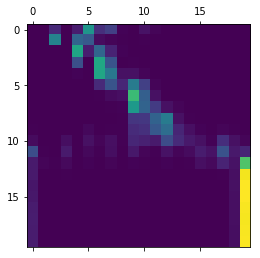

In [28]:
# 将每一步存储的注意力权重组合到一起就形成了注意力矩阵，绘制为图
plt.matshow(decoder_attentions.numpy())